In [ ]:
import os
import cv2
import math
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from typing import List, Optional, Callable, Dict, Any, Tuple
import time

import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models._utils import IntermediateLayerGetter
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
import time
from contextlib import nullcontext
from tqdm import tqdm
import wandb
from shapely.geometry import Polygon
from shapely.errors import TopologicalError
from torchinfo import summary


In [4]:


def set_seed(seed_value: int = 42) -> None:
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed_value (int): The random seed value to be used.

    Returns:
        None
    """

    # Setting the random seed for numpy's random number generator
    np.random.seed(seed_value)

    # Setting the random seed for PyTorch's random number generator and the CUDA random number generator
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Setting the random seed for Python's built-in random library
    random.seed(seed_value)


class BabyFacesDataset(Dataset):
    """
    PyTorch Dataset class for loading baby face images and their associated oriented bounding box (OBB) annotations.

    Each image may have one or more annotations stored in a corresponding .txt label file.
    Label format per line:
        class_idx x1 y1 x2 y2 x3 y3 x4 y4 angle

    - class_idx: integer from 0 to 4 indicating face orientation
        (0 = 3/4 leftside, 1 = 3/4 rightside, 2 = frontal, 3 = left profile, 4 = right profile)
    - x1, y1, ..., x4, y4: normalized (0–1) coordinates of the OBB corners
    - angle: rotation angle in radians (clockwise), usually measured from the top-left corner

    Images without a corresponding label file are treated as background and assigned class index 5.

    It is assumed the dataset is organized as:
        root_dir/
            train/
                images/
                labels/
            val/
                images/
                labels/
            ...

    Args:
        root_dir (str): Path to the root directory of the dataset.
        split (str): Subdirectory name indicating the split ("train", "val", "test", etc.). Defaults to "train".
        file_list (Optional[List[str]]): List of image base names (without extension) to load. If None, all .jpg files in the image directory will be used. Defaults to None.
        transform (Optional[Callable]): A function or transform to apply to each sample. Defaults to None.
    """

    def __init__(
        self,
        root_dir: str,
        split: str = "train",
        file_list: Optional[List[str]] = None,
        transform: Optional[Callable] = None,
    ):
        """
        Initializes the BabyFacesDataset.

        Args:
            root_dir (str): Path to the root directory of the dataset.
            split (str): Subdirectory name indicating the split ("train", "val", "test", etc.). Defaults to "train".
            file_list (Optional[List[str]]): List of image base names (without extension) to load. If None, all .jpg files in the image directory will be used. Defaults to None.
            transform (Optional[Callable]): A function or transform to apply to each sample. Defaults to None.
        """
        self.root_dir = root_dir  # Assigns the root directory of the dataset.
        self.split = split  # Assigns the split (train, val, test, etc.).
        self.transform = transform  # Assigns the transform to apply to each sample.

        self.images_dir = os.path.join(root_dir, split, "images")  # Constructs the path to the images directory.
        self.labels_dir = os.path.join(root_dir, split, "labels")  # Constructs the path to the labels directory.

        if file_list is None:  # Checks if a file list is provided.
            self.file_list = [  # Creates a list of image base names from the images directory.
                os.path.splitext(f)[0]
                for f in os.listdir(self.images_dir)
                if f.lower().endswith(".jpg")
            ]
        else:
            self.file_list = file_list  # Assigns the provided file list.

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            int: The number of images.
        """
        return len(self.file_list)  # Returns the length of the file list.

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Retrieves an image and its corresponding target (bounding boxes, angles, class indices) given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            Dict[str, Any]: A dictionary containing the image and its target.
                - "image": The image as a NumPy array (H, W, C).
                - "target": A dictionary containing the target information:
                    - "boxes": A torch tensor of shape (N, 8) representing the oriented bounding box coordinates in pixel space.
                    - "angles": A torch tensor of shape (N,) representing the rotation angles in radians.
                    - "class_idxs": A torch tensor of shape (N,) or (1,) if background, representing the class indices.
        """
        base_name = self.file_list[idx]  # Gets the base name of the image from the file list.
        img_path = os.path.join(self.images_dir, base_name + ".jpg")  # Constructs the path to the image.
        label_path = os.path.join(self.labels_dir, base_name + ".txt")  # Constructs the path to the label file.

        # Load image in RGB format
        image = cv2.imread(img_path)  # Reads the image using OpenCV.
        if image is None:  # Checks if the image was loaded successfully.
            raise FileNotFoundError(f"Could not read image file: {img_path}")  # Raises an error if the image could not be read.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converts the image from BGR to RGB.
        height, width = image.shape[:2]  # Gets the height and width of the image.

        boxes = []  # List of flattened (x1, y1, ..., x4, y4) in pixel coordinates
        angles = []  # Rotation angles in radians
        class_idxs = []  # Class indices

        if os.path.exists(label_path):  # Checks if the label file exists.
            with open(label_path, "r") as f:  # Opens the label file for reading.
                for line in f:  # Iterates over each line in the label file.
                    parts = line.strip().split()  # Splits the line into parts.
                    if len(parts) != 10:  # Checks if the line has the correct number of parts.
                        continue  # Skips malformed lines.

                    class_idx = int(parts[0])  # Gets the class index.
                    coords = list(map(float, parts[1:9]))  # Gets the coordinates.
                    angle = float(parts[9])  # Gets the angle.

                    coords_px = []  # List to store coordinates in pixel space.
                    for i in range(0, 8, 2):  # Iterates over the coordinates.
                        x = coords[i] * width  # Calculates the x-coordinate in pixel space.
                        y = coords[i + 1] * height  # Calculates the y-coordinate in pixel space.
                        coords_px.extend([x, y])  # Adds the coordinates to the list.

                    class_idxs.append(class_idx)  # Adds the class index to the list.
                    boxes.append(coords_px)  # Adds the coordinates to the list.
                    angles.append(angle)  # Adds the angle to the list.
        else:
            # Background image — no boxes or angles, just class index 5
            class_idxs.append(5)  # Adds class index 5 for background images.

        # Build target dictionary
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),  # shape (N, 8) or (0, 8)
            "angles": torch.tensor(angles, dtype=torch.float32),  # shape (N,) or (0,)
            "class_idxs": torch.tensor(class_idxs, dtype=torch.long),  # shape (N,) or (1,) if background
        }

        sample = {
            "image": image,
            "target": target,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
def compute_dataset_mean_std(dataset: Dataset, max_samples: Optional[int] = None) -> Tuple[List[float], List[float]]:
    """
    Computes the mean and standard deviation per channel for the given dataset.

    Args:
        dataset (Dataset): A PyTorch dataset returning samples with key "image".
        max_samples (Optional[int]): If specified, limits the number of samples processed.

    Returns:
        tuple: (mean, std) as 3-element lists for RGB channels.
    """
    mean = torch.zeros(3)  # Initializes a tensor to store the sum of pixel values for each channel.
    std = torch.zeros(3)  # Initializes a tensor to store the sum of squared pixel values for each channel.
    n_pixels = 0  # Initializes a variable to store the total number of pixels.

    num_samples = len(dataset) if max_samples is None else min(len(dataset), max_samples)  # Determines the number of samples to process.

    for i in range(num_samples):  # Iterates through the specified number of samples.
        sample = dataset[i]  # Retrieves the i-th sample from the dataset.
        image = sample["image"]  # numpy array HxWxC, uint8. Retrieves the image from the sample as a NumPy array.

        # Convert image to float32
        image = torch.from_numpy(image).float() / 255.0  # CxHxW. Converts the image to a float tensor and normalizes it to [0, 1].
        image = image.permute(2, 0, 1)  # Convert to CxHxW. Permutes the image tensor to have channels first (C, H, W).

        n = image.numel() // 3  # pixels per channel. Calculates the number of pixels per channel.
        mean += image.sum(dim=[1, 2])  # Adds the sum of pixel values for each channel to the mean tensor.
        std += (image ** 2).sum(dim=[1, 2])  # Adds the sum of squared pixel values for each channel to the std tensor.
        n_pixels += n  # Adds the number of pixels per channel to the total number of pixels.

    mean /= n_pixels  # Calculates the mean pixel value for each channel.
    std = (std / n_pixels - mean ** 2).sqrt()  # Calculates the standard deviation for each channel.

    return mean.tolist(), std.tolist()

In [6]:
class Resize(object):
    """
    Resizes the image to a fixed size and adjusts the bounding boxes accordingly.
    The size is expected to be specified as (width, height).
    """

    def __init__(self, size: Tuple[int, int]):
        """
        Initializes the Resize transform.

        Args:
            size (Tuple[int, int]): The desired (width, height) of the resized image.
        """
        self.size = size  # (width, height)

    def __call__(self, sample: dict) -> dict:
        """
        Applies the resize transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.
        new_w, new_h = self.size  # Gets the new width and height.

        # Resize the image
        image_resized = cv2.resize(image, (new_w, new_h))  # Resizes the image using OpenCV.

        # Adjust the boxes: since the coordinates are in pixels,
        # we multiply by the scaling factor in each axis.
        scale_x = new_w / w  # Calculates the scaling factor for the x-axis.
        scale_y = new_h / h  # Calculates the scaling factor for the y-axis.
        boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
        # Each row has [x1, y1, x2, y2, x3, y3, x4, y4]
        for i in range(boxes.shape[0]):  # Iterates through each bounding box.
            box = boxes[i]  # Gets the i-th bounding box.
            box[0] *= scale_x  # Scales the x1 coordinate.
            box[2] *= scale_x  # Scales the x2 coordinate.
            box[4] *= scale_x  # Scales the x3 coordinate.
            box[6] *= scale_x  # Scales the x4 coordinate.
            box[1] *= scale_y  # Scales the y1 coordinate.
            box[3] *= scale_y  # Scales the y2 coordinate.
            box[5] *= scale_y  # Scales the y3 coordinate.
            box[7] *= scale_y  # Scales the y4 coordinate.
            boxes[i] = box  # Updates the bounding box in the tensor.

        target["boxes"] = boxes  # Updates the boxes in the target dictionary.
        sample["image"] = image_resized  # Updates the resized image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample


class RandomHorizontalFlipOBB:
    """
    Applies a horizontal flip to the image and updates:
    - OBB coordinates
    - angles (negated)
    - class indices (0↔1, 3↔4)
    """

    def __init__(self, prob: float = 0.5):
        """
        Initializes the RandomHorizontalFlipOBB transform.

        Args:
            prob (float): The probability of applying the flip. Defaults to 0.5.
        """
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the horizontal flip transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        if random.random() < self.prob:  # Checks if the flip should be applied.
            h, w = image.shape[:2]  # Gets the height and width of the image.
            # Flip image
            image = np.fliplr(image).copy()  # Flips the image horizontally.

            boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
            angles = target["angles"].clone()  # Creates a copy of the angles tensor.
            class_idxs = target["class_idxs"].clone()  # Creates a copy of the class indices tensor.

            for i in range(boxes.shape[0]):  # Iterates through each bounding box.
                box = boxes[i].view(4, 2)  # Reshapes the bounding box to (4, 2).
                box[:, 0] = w - box[:, 0]  # Flips the X coordinates.
                box = box[[1, 0, 3, 2]]  # Reorders the coordinates to keep the OBB orientation.
                boxes[i] = box.view(-1)  # Reshapes the bounding box back to (8,).

                angles[i] = -angles[i]  # Negates the angle.

                # Flip class indices
                if class_idxs[i] == 0:  # Flips class index 0 to 1.
                    class_idxs[i] = 1
                elif class_idxs[i] == 1:  # Flips class index 1 to 0.
                    class_idxs[i] = 0
                elif class_idxs[i] == 3:  # Flips class index 3 to 4.
                    class_idxs[i] = 4
                elif class_idxs[i] == 4:  # Flips class index 4 to 3.
                    class_idxs[i] = 3

            target["boxes"] = boxes  # Updates the boxes in the target dictionary.
            target["angles"] = angles  # Updates the angles in the target dictionary.
            target["class_idxs"] = class_idxs  # Updates the class indices in the target dictionary.

        sample["image"] = image  # Updates the image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample


class RandomRotateOBB:
    """
    Randomly rotates the image and OBBs by an angle in degrees between [-max_angle, max_angle],
    expanding the canvas to avoid cropping, and normalizing the resulting angles.
    """

    def __init__(self, max_angle: int = 180, prob: float = 0.5):
        """
        Initializes the RandomRotateOBB transform.

        Args:
            max_angle (int): The maximum rotation angle in degrees. Defaults to 180.
            prob (float): The probability of applying the rotation. Defaults to 0.5.
        """
        self.max_angle = max_angle
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random rotation transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the rotation should be applied.
            return sample

        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.
        angle_deg = -random.uniform(-self.max_angle, self.max_angle)  # clockwise. Generates a random rotation angle.
        angle_rad = np.radians(angle_deg)  # Converts the angle to radians.

        # Compute new canvas size
        abs_cos = abs(math.cos(angle_rad))  # Calculates the absolute cosine of the angle.
        abs_sin = abs(math.sin(angle_rad))  # Calculates the absolute sine of the angle.
        new_w = int(h * abs_sin + w * abs_cos)  # Calculates the new width of the canvas.
        new_h = int(h * abs_cos + w * abs_sin)  # Calculates the new height of the canvas.

        # Compute rotation matrix and adjust for canvas shift
        center = (w / 2, h / 2)  # Calculates the center of the image.
        rot_mat = cv2.getRotationMatrix2D(center, angle_deg, 1.0)  # Gets the rotation matrix.
        rot_mat[0, 2] += (new_w - w) / 2  # Adjusts the rotation matrix for the canvas shift.
        rot_mat[1, 2] += (new_h - h) / 2  # Adjusts the rotation matrix for the canvas shift.

        # Rotate image with expanded canvas
        rotated_image = cv2.warpAffine(image, rot_mat, (new_w, new_h), flags=cv2.INTER_LINEAR)  # Rotates the image.

        boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
        angles = target["angles"].clone()  # Creates a copy of the angles tensor.
        class_idxs = target["class_idxs"].clone()  # Creates a copy of the class indices tensor.

        for i in range(boxes.shape[0]):  # Iterates through each bounding box.
            box = boxes[i].view(4, 2).numpy()  # Reshapes the bounding box to (4, 2) and converts it to a NumPy array.
            ones = np.ones((4, 1))  # Creates a tensor of ones for homogeneous coordinates.
            box_hom = np.hstack([box, ones])  # Concatenates the bounding box with the ones.
            rotated_box = np.dot(rot_mat, box_hom.T).T  # Rotates the bounding box.
            boxes[i] = torch.tensor(rotated_box.flatten(), dtype=torch.float32)  # Updates the bounding box in the tensor.

            # Update angle and normalize to [0, 2π)
            new_angle = normalize_angle(angles[i].item() + angle_rad)  # Calculates the new angle and normalizes it.
            angles[i] = new_angle  # Updates the angle in the tensor.

        target["boxes"] = boxes  # Updates the boxes in the target dictionary.
        target["angles"] = angles  # Updates the angles in the target dictionary.
        target["class_idxs"] = class_idxs  # Updates the class indices in the target dictionary.

        sample["image"] = rotated_image  # Updates the rotated image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample


def normalize_angle(angle_rad: float) -> float:
    """
    Normalizes an angle in radians to the range [0, 2π).
    """
    return angle_rad % (2 * math.pi)  # Calcula el ángulo normalizado.


class RandomScaleTranslateOBB:
    """
    Randomly scales and translates the image and its OBBs.
    Canvas is expanded to avoid cropping. OBBs completely outside the frame are removed.
    """

    def __init__(self, scale_range: Tuple[float, float] = (0.9, 1.1), translate_range: Tuple[float, float] = (-0.2, 0.2), prob: float = 0.5):
        """
        Initializes the RandomScaleTranslateOBB transform.

        Args:
            scale_range (Tuple[float, float]): The range of scaling factors. Defaults to (0.9, 1.1).
            translate_range (Tuple[float, float]): The range of translation factors. Defaults to (-0.2, 0.2).
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.scale_range = scale_range
        self.translate_range = translate_range
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random scale and translate transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image, target = sample["image"], sample["target"]  # Extracts the image and target from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.

        # Sample scale factor and translations
        scale = random.uniform(*self.scale_range)  # Generates a random scaling factor.
        tx = random.uniform(*self.translate_range) * w  # Generates a random translation in the x-axis.
        ty = random.uniform(*self.translate_range) * h  # Generates a random translation in the y-axis.

        # New canvas size to accommodate transformed image
        new_w = int(w * scale + abs(tx))  # Calculates the new width of the canvas.
        new_h = int(h * scale + abs(ty))  # Calculates the new height of the canvas.

        # Build affine matrix
        M = np.array([
            [scale, 0, tx if tx > 0 else -tx],
            [0, scale, ty if ty > 0 else -ty]
        ], dtype=np.float32)  # Creates the affine transformation matrix.

        # Transform image
        transformed_image = cv2.warpAffine(image, M, (new_w, new_h), flags=cv2.INTER_LINEAR)  # Transforms the image.

        boxes = target["boxes"].clone()  # Creates a copy of the bounding boxes tensor.
        angles = target["angles"].clone()  # Creates a copy of the angles tensor.
        class_idxs = target["class_idxs"].clone()  # Creates a copy of the class indices tensor.

        valid_boxes = []  # List to store valid bounding boxes.
        valid_angles = []  # List to store valid angles.
        valid_class_idxs = []  # List to store valid class indices.

        for i in range(boxes.shape[0]):  # Iterates through each bounding box.
            box = boxes[i].view(4, 2).numpy()  # Reshapes the bounding box to (4, 2) and converts it to a NumPy array.
            ones = np.ones((4, 1))  # Creates a tensor of ones for homogeneous coordinates.
            box_hom = np.hstack([box, ones])  # Concatenates the bounding box with the ones.
            transformed_box = np.dot(M, box_hom.T).T  # Transforms the bounding box.

            # Check if all points are within the new image
            if np.all((0 <= transformed_box[:, 0]) & (transformed_box[:, 0] < new_w) &
                      (0 <= transformed_box[:, 1]) & (transformed_box[:, 1] < new_h)):  # Checks if the bounding box is within the new image.
                valid_boxes.append(transformed_box.flatten())  # Adds the transformed bounding box to the list.
                valid_angles.append(angles[i].item())  # angle doesn't change. Adds the angle to the list.
                valid_class_idxs.append(class_idxs[i].item())  # Adds the class index to the list.

        # Build target
        if len(valid_boxes) == 0:  # Checks if there are any valid bounding boxes.
            target["boxes"] = torch.empty((0, 8), dtype=torch.float32)  # Creates an empty tensor for boxes.
            target["angles"] = torch.empty((0,), dtype=torch.float32)  # Creates an empty tensor for angles.
            target["class_idxs"] = torch.tensor([5], dtype=torch.long)  # background. Creates a tensor for background class index.
        else:
            target["boxes"] = torch.tensor(np.array(valid_boxes), dtype=torch.float32)  # Creates a tensor for valid boxes.
            target["angles"] = torch.tensor(valid_angles, dtype=torch.float32)  # Creates a tensor for valid angles.
            target["class_idxs"] = torch.tensor(valid_class_idxs, dtype=torch.long)  # Creates a tensor for valid class indices.

        sample["image"] = transformed_image  # Updates the transformed image in the sample.
        sample["target"] = target  # Updates the target in the sample.
        return sample


class ColorJitterOBB:
    """
    Randomly changes the brightness, contrast, and saturation of the image.
    This does not affect the OBBs or angles.
    """

    def __init__(self, brightness: float = 0.2, contrast: float = 0.2, saturation: float = 0.2, prob: float = 0.5):
        """
        Initializes the ColorJitterOBB transform.

        Args:
            brightness (float): The brightness adjustment factor. Defaults to 0.2.
            contrast (float): The contrast adjustment factor. Defaults to 0.2.
            saturation (float): The saturation adjustment factor. Defaults to 0.2.
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the color jitter transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample
        image = sample["image"].astype(np.float32)  # Converts the image to float32.

        # Brightness
        if self.brightness > 0:  # Checks if brightness adjustment should be applied.
            factor = 1.0 + random.uniform(-self.brightness, self.brightness)  # Generates a random brightness factor.
            image *= factor  # Adjusts the brightness of the image.

        # Contrast
        if self.contrast > 0:  # Checks if contrast adjustment should be applied.
            mean = image.mean(axis=(0, 1), keepdims=True)  # Calculates the mean of the image.
            factor = 1.0 + random.uniform(-self.contrast, self.contrast)  # Generates a random contrast factor.
            image = (image - mean) * factor + mean  # Adjusts the contrast of the image.

        # Saturation (only affects RGB, so convert to HSV)
        if self.saturation > 0:  # Checks if saturation adjustment should be applied.
            hsv = cv2.cvtColor(np.clip(image, 0, 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)  # Converts the image to HSV.
            factor = 1.0 + random.uniform(-self.saturation, self.saturation)  # Generates a random saturation factor.
            hsv[..., 1] *= factor  # Adjusts the saturation of the image.
            hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)  # Clips the saturation values to [0, 255].
            image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)  # Converts the image back to RGB.

        sample["image"] = np.clip(image, 0, 255).astype(np.uint8)  # Clips the image values to [0, 255] and converts it to uint8.
        return sample


class RandomNoiseOBB:
    """
    Adds random Gaussian noise to the image.
    """

    def __init__(self, std: float = 10, prob: float = 0.5):
        """
        Initializes the RandomNoiseOBB transform.

        Args:
            std (float): The standard deviation of the Gaussian noise. Defaults to 10.
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.std = std
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random noise transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample
        image = sample["image"].astype(np.float32)  # Converts the image to float32.
        noise = np.random.normal(0, self.std, image.shape).astype(np.float32)  # Generates random Gaussian noise.
        image = np.clip(image + noise, 0, 255).astype(np.uint8)  # Adds the noise to the image and clips the values to [0, 255].
        sample["image"] = image  # Updates the image in the sample.
        return sample


class RandomBlurOBB:
    """
    Applies Gaussian blur to simulate low-quality or motion blur.
    """

    def __init__(self, ksize: Tuple[int, int] = (5, 5), prob: float = 0.5):
        """
        Initializes the RandomBlurOBB transform.

        Args:
            ksize (Tuple[int, int]): The kernel size for the Gaussian blur. Defaults to (5, 5).
            prob (float): The probability of applying the transform. Defaults to 0.5.
        """
        self.ksize = ksize
        self.prob = prob

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random blur transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample
        image = sample["image"]  # Gets the image from the sample.
        blurred = cv2.GaussianBlur(image, self.ksize, 0)  # Applies Gaussian blur to the image.
        sample["image"] = blurred  # Updates the blurred image in the sample.
        return sample


class RandomOcclusionOBB:
    """
    Randomly occludes a rectangular area inside an OBB (or anywhere in the image).
    If `target_inside_obb=True`, the occlusion is constrained to the selected OBB area.
    The patch size is calculated relative to the size of the OBB instead of the whole image.
    """

    def __init__(self, max_size_ratio: float = 0.5, prob: float = 0.5, target_inside_obb: bool = True):
        """
        Initializes the RandomOcclusionOBB transform.

        Args:
            max_size_ratio (float): The maximum size ratio of the occlusion patch. Defaults to 0.5.
            prob (float): The probability of applying the transform. Defaults to 0.5.
            target_inside_obb (bool): Whether to constrain the occlusion to the OBB area. Defaults to True.
        """
        self.max_size_ratio = max_size_ratio
        self.prob = prob
        self.target_inside_obb = target_inside_obb

    def __call__(self, sample: dict) -> dict:
        """
        Applies the random occlusion transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        if random.random() > self.prob:  # Checks if the transform should be applied.
            return sample

        image = sample["image"]  # Gets the image from the sample.
        h, w = image.shape[:2]  # Gets the height and width of the image.

        if self.target_inside_obb and "boxes" in sample["target"] and len(sample["target"]["boxes"]) > 0:  # Checks if the occlusion should be inside an OBB.
            # Select a random OBB
            obb = sample["target"]["boxes"][random.randint(0, len(sample["target"]["boxes"]) - 1)].view(4, 2).numpy()  # Selects a random OBB.
            x_min, y_min = obb.min(axis=0)  # Gets the minimum x and y coordinates of the OBB.
            x_max, y_max = obb.max(axis=0)  # Gets the maximum x and y coordinates of the OBB.
            obb_w = max(x_max - x_min, 1)  # Calculates the width of the OBB.
            obb_h = max(y_max - y_min, 1)  # Calculates the height of the OBB.

            occ_w = int(random.uniform(0.1, self.max_size_ratio) * obb_w)  # Calculates the width of the occlusion patch.
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * obb_h)  # Calculates the height of the occlusion patch.

            # Clamp occlusion position within the OBB bounding rectangle
            max_x = int(max(x_min, 0))  # Gets the maximum x coordinate for the occlusion.
            max_y = int(max(y_min, 0))  # Gets the maximum y coordinate for the occlusion.
            range_x = max(int(x_max - occ_w), max_x + 1)  # Calculates the range for the x coordinate of the occlusion.
            range_y = max(int(y_max - occ_h), max_y + 1)  # Calculates the range for the y coordinate of the occlusion.

            x0 = random.randint(max_x, max(range_x, max_x + 1))  # Generates a random x coordinate for the occlusion.
            y0 = random.randint(max_y, max(range_y, max_y + 1))  # Generates a random y coordinate for the occlusion.
        else:
            # Occlusion anywhere in the image
            occ_w = int(random.uniform(0.1, self.max_size_ratio) * w)  # Calculates the width of the occlusion patch.
            occ_h = int(random.uniform(0.1, self.max_size_ratio) * h)  # Calculates the height of the occlusion patch.
            x0 = random.randint(0, max(w - occ_w, 1))  # Generates a random x coordinate for the occlusion.
            y0 = random.randint(0, max(h - occ_h, 1))  # Generates a random y coordinate for the occlusion.

        # Apply occlusion
        image[y0:y0 + occ_h, x0:x0 + occ_w] = 0  # Applies the occlusion to the image.
        sample["image"] = image  # Updates the image in the sample.
        return sample


class ToTensorNormalize(object):
    """
    Converts the image (HxWxC numpy array) to a PyTorch tensor (CxHxW)
    and normalizes it using provided mean and std values.
    """

    def __init__(self, mean: Tuple[float, float, float] = (0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                 std: Tuple[float, float, float] = (0.2812318801879883, 0.28248199820518494, 0.3035854697227478)):
        """
        Initializes the ToTensorNormalize transform.

        Args:
            mean (Tuple[float, float, float]): The mean values for normalization. Defaults to (0.6427208185195923, 0.5918306708335876, 0.5525837540626526).
            std (Tuple[float, float, float]): The standard deviation values for normalization. Defaults to (0.2812318801879883, 0.28248199820518494, 0.3035854697227478).
        """
        self.mean = torch.tensor(mean).view(3, 1, 1)  # Creates a tensor for the mean values.
        self.std = torch.tensor(std).view(3, 1, 1)  # Creates a tensor for the standard deviation values.

    def __call__(self, sample: dict) -> dict:
        """
        Applies the to tensor and normalize transform to the given sample.

        Args:
            sample (dict): A dictionary containing the image and target information.

        Returns:
            dict: The transformed sample.
        """
        image, target = sample["image"], sample["target"]  # Gets the image and target from the sample.
        image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0  # Converts the image to a PyTorch tensor and normalizes it.
        image = (image - self.mean) / self.std  # Normalizes the image using the mean and standard deviation.
        sample["image"] = image  # Updates the normalized image in the sample.
        return sample


# Ejemplo de composición de transformaciones usando torchvision.transforms.Compose
transform = transforms.Compose([RandomHorizontalFlipOBB(prob=0.5),
                                RandomRotateOBB(max_angle=180, prob=0.3),
                                RandomScaleTranslateOBB(scale_range=(0.8, 1.1), translate_range=(-0.2, 0.2), prob=0.3),
                                ColorJitterOBB(brightness=0.2, contrast=0.2, saturation=0.2, prob=0.5),
                                RandomNoiseOBB(std=10, prob=0.5),
                                RandomBlurOBB(ksize=(5, 5), prob=0.3),
                                RandomOcclusionOBB(max_size_ratio=0.3, prob=0.3),
                                Resize((640, 640)),
                                ToTensorNormalize(mean=(0.6427208185195923, 0.5918306708335876, 0.5525837540626526),
                                                  std=(0.2812318801879883, 0.28248199820518494, 0.3035854697227478))])


In [7]:
def calculate_average_obb_dimensions(dataset: Dataset) -> Dict[str, float]:
    """
    Calculates the average size, width, height, and aspect ratio of oriented bounding boxes (OBBs) in a dataset.

    Args:
        dataset (Dataset): A PyTorch dataset where each sample contains OBB annotations in the "target" dictionary.

    Returns:
        Dict[str, float]: A dictionary containing the average OBB size, width, height, and aspect ratio.
            - "avg_size": The average of the average dimensions (width + height) / 2.
            - "avg_width": The average width of the OBBs.
            - "avg_height": The average height of the OBBs.
            - "avg_ratio": The average height-to-width ratio of the OBBs.
    """
    sizes = []  # List to store the average dimensions of each OBB.
    widths = []  # List to store the widths of each OBB.
    heights = []  # List to store the heights of each OBB.
    ratios = []  # List to store the aspect ratios (height / width) of each OBB.

    for i in range(len(dataset)):  # Iterates through each sample in the dataset.
        sample = dataset[i]  # Retrieves the i-th sample.
        for box in sample["target"]["boxes"]:  # Iterates through each OBB in the sample.
            pts = box.view(4, 2)  # Reshapes the OBB tensor to (4, 2) for easier coordinate access.
            w = torch.norm(pts[1] - pts[0])  # Calculates the width of the OBB (distance between top-right and top-left points).
            h = torch.norm(pts[2] - pts[1])  # Calculates the height of the OBB (distance between bottom-right and top-right points).
            size = (w + h) / 2  # Calculates the average dimension of the OBB.
            sizes.append(size.item())  # Appends the average dimension to the sizes list.
            widths.append(w.item())  # Appends the width to the widths list.
            heights.append(h.item())  # Appends the height to the heights list.
            ratios.append((h / w).item())  # Appends the aspect ratio to the ratios list.

    return {
        "avg_size": sum(sizes) / len(sizes),  # Calculates the average OBB size.
        "avg_width": sum(widths) / len(widths),  # Calculates the average OBB width.
        "avg_height": sum(heights) / len(heights),  # Calculates the average OBB height.
        "avg_ratio": sum(ratios) / len(ratios)  # Calculates the average OBB aspect ratio.
    }


In [8]:
# # Create a version of the dataset without normalization
# raw_dataset = BabyFacesDataset(
#     root_dir="/Users/jocareher/Downloads/new_dataset/obbabyface_rot",
#     split="train",
#     transform=transform  # Resize only, no normalization
# )

# # mean, std = compute_dataset_mean_std(raw_dataset)
# # print("Dataset mean:", mean)
# # print("Dataset std:", std)

# stats = calcular_tamaños_promedio(raw_dataset)
# print(stats)

In [9]:
def custom_collate(batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Custom collate function that stacks images, pads the target tensors,
    and generates a 'valid_mask' to indicate the presence of valid objects.

    Args:
        batch (List[Dict[str, Any]]): A list of dictionaries, where each dictionary represents a sample
                                      with "image" and "target" keys.

    Returns:
        Dict[str, Any]: A dictionary containing the stacked images and padded targets, including a valid mask.
            - "image": A tensor of stacked images (B, C, H, W).
            - "target": A dictionary containing:
                - "boxes": A tensor of padded bounding boxes (B, max_N, 8).
                - "angles": A tensor of padded angles (B, max_N).
                - "class_idx": A tensor of padded class indices (B, max_N).
                - "valid_mask": A boolean mask indicating valid object positions (B, max_N).
    """
    images = torch.stack([item["image"] for item in batch], dim=0)  # Stack images into a single tensor.

    # Determine the maximum number of objects per image in the batch.
    max_num_objs = max(item["target"]["boxes"].shape[0] for item in batch)

    padded_boxes = []  # List to store padded bounding box tensors.
    padded_angles = []  # List to store padded angle tensors.
    padded_classes = []  # List to store padded class index tensors.
    valid_masks = []  # List to store valid object masks.

    for item in batch:  # Iterate through each sample in the batch.
        boxes = item["target"]["boxes"]  # Get the bounding box tensor.
        angles = item["target"]["angles"]  # Get the angle tensor.
        classes = item["target"]["class_idxs"]  # Get the class index tensor.
        n = boxes.shape[0]  # Get the number of objects in the current sample.
        pad_size = max_num_objs - n  # Calculate the padding size.

        # Handle the case where there are no objects (pure background).
        if n == 0:
            boxes = torch.zeros((0, 8), dtype=torch.float32)
            angles = torch.zeros((0,), dtype=torch.float32)
            classes = torch.full((0,), fill_value=5, dtype=torch.long)  # 5 = no face

        padded_boxes.append(F.pad(boxes, (0, 0, 0, pad_size)))  # Pad the bounding boxes tensor.
        padded_angles.append(F.pad(angles, (0, pad_size)))  # Pad the angles tensor.
        padded_classes.append(F.pad(classes, (0, pad_size), value=5))  # Pad the class indices tensor.

        mask = torch.zeros(max_num_objs, dtype=torch.bool)  # Create a mask tensor.
        mask[:n] = True  # Set the first 'n' elements to True.
        valid_masks.append(mask)  # Append the mask to the list.

    targets = {
        "boxes": torch.stack(padded_boxes),  # Stack the padded bounding boxes.
        "angles": torch.stack(padded_angles),  # Stack the padded angles.
        "class_idx": torch.stack(padded_classes),  # Stack the padded class indices.
        "valid_mask": torch.stack(valid_masks)  # Stack the valid object masks.
    }

    return {"image": images, "target": targets}  # Return the stacked images and padded targets.


In [10]:
# Supongamos que en 'root_dir' tenemos archivos .jpg y .txt correspondientes.
root_dir = "/Users/jocareher/Downloads/new_dataset/obbabyface_rot_2"


train_dataset = BabyFacesDataset(root_dir=root_dir, split="train", transform=transform)

val_dataset = BabyFacesDataset(root_dir=root_dir, split="val", transform=transform)

test_dataset = BabyFacesDataset(root_dir=root_dir, split="test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)


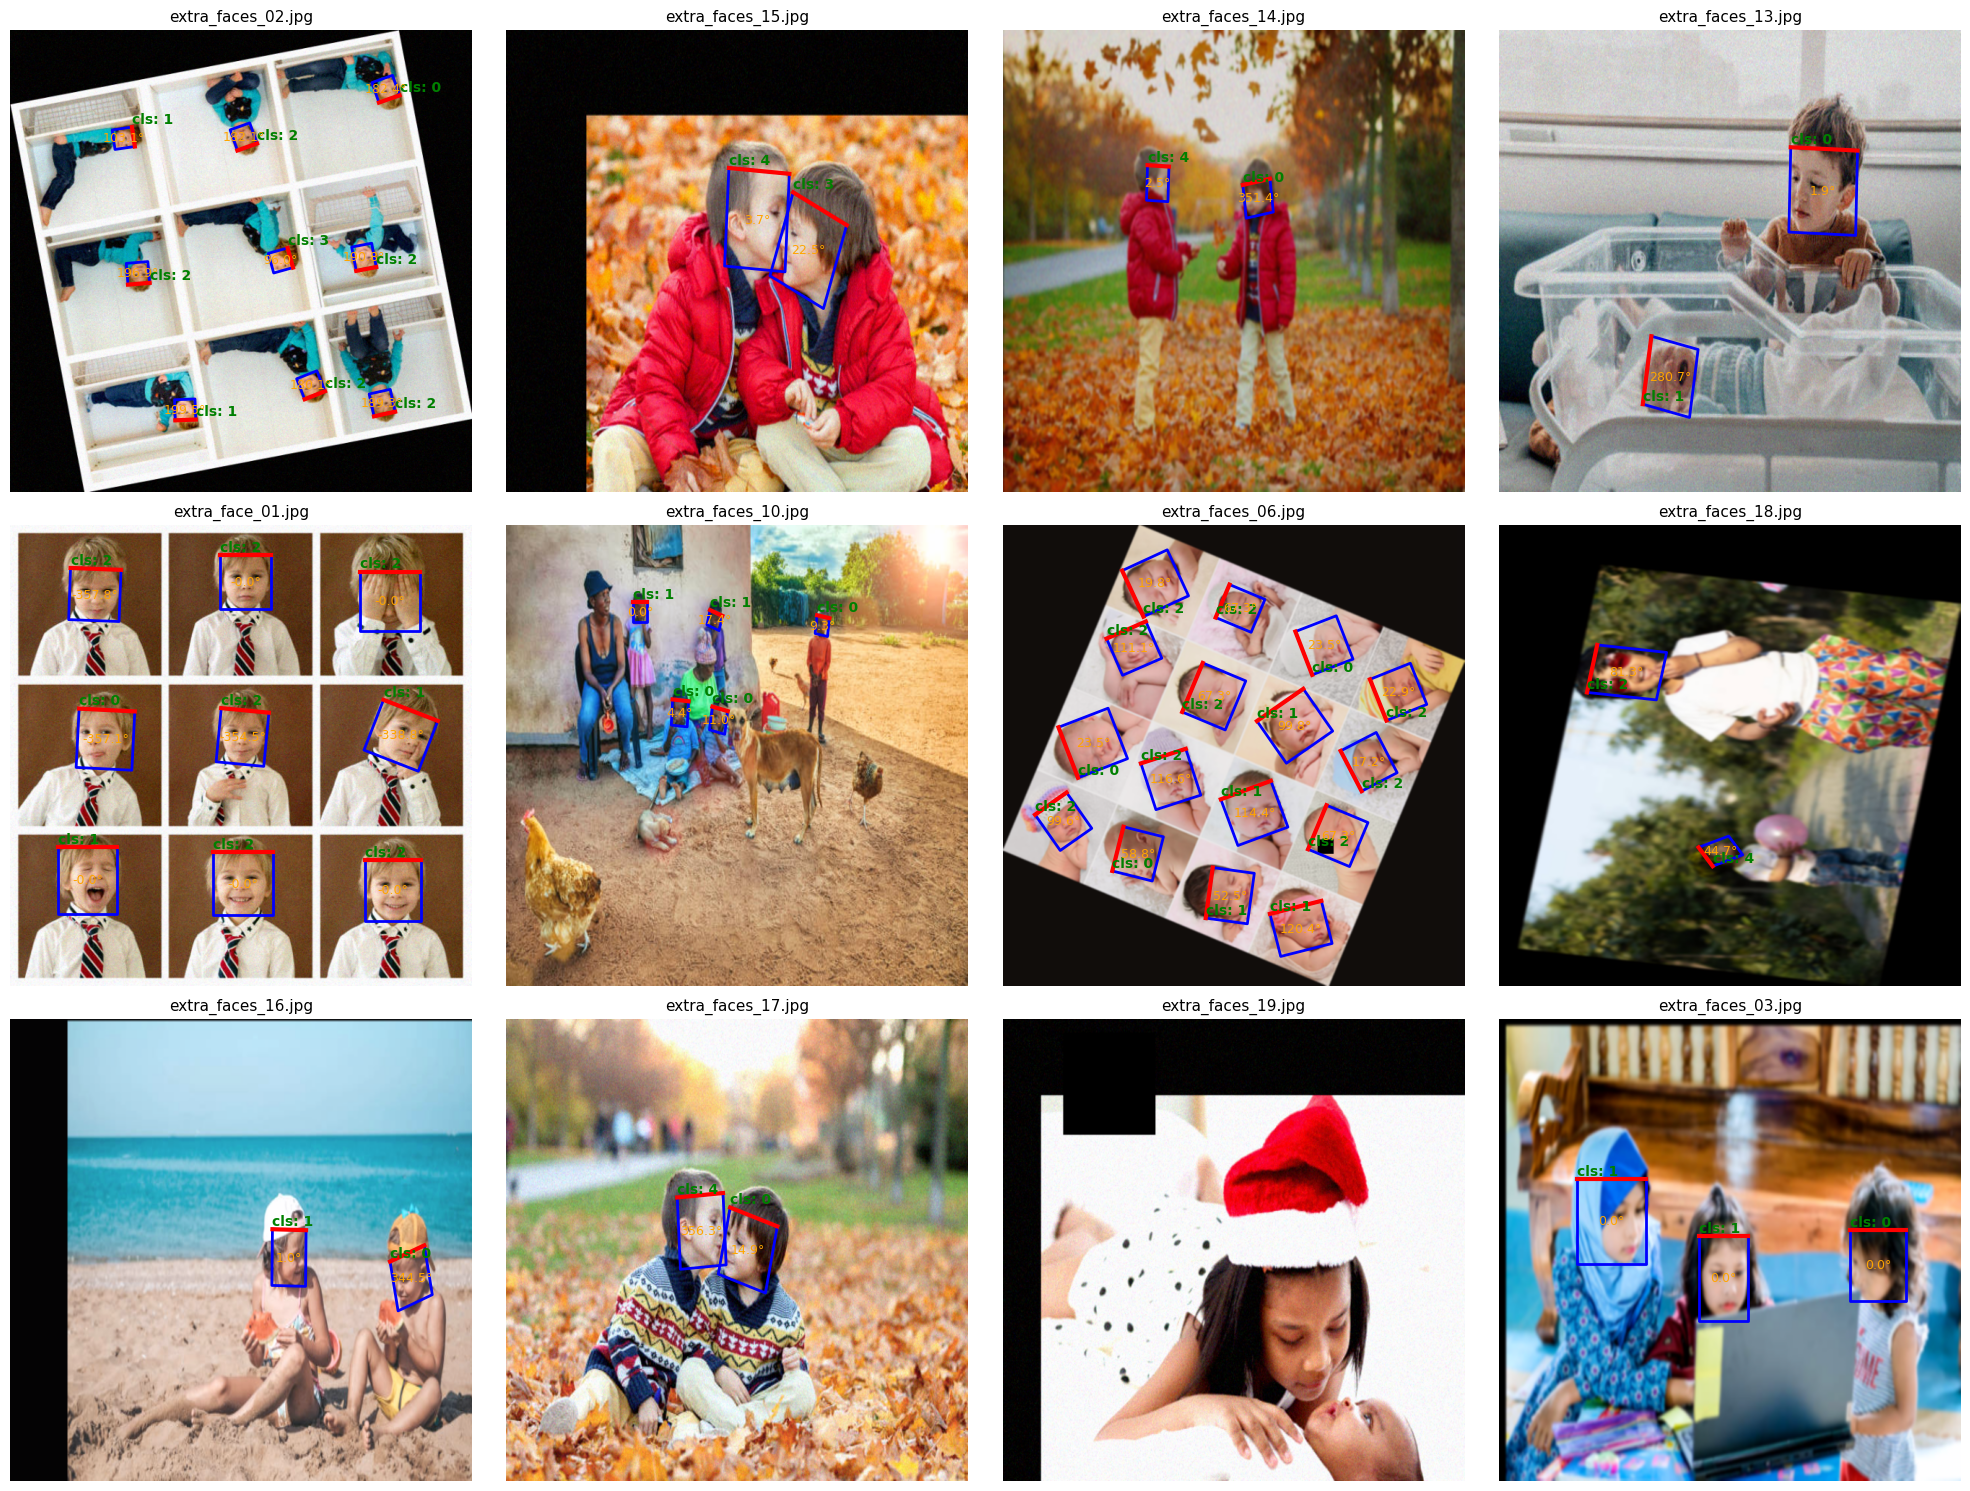

In [11]:
def denormalize_image(img_tensor: torch.Tensor, mean: Tuple[float, float, float] = (0.6427, 0.5918, 0.5526),
                      std: Tuple[float, float, float] = (0.2812, 0.2825, 0.3036)) -> np.ndarray:
    """
    Converts a normalized image tensor (C x H x W) back to a NumPy array (H x W x C) in uint8 format.
    
    Args:
        img_tensor (Tensor): The normalized image tensor.
        mean (tuple): Mean used during normalization (per channel).
        std (tuple): Std used during normalization (per channel).
    
    Returns:
        np.ndarray: Denormalized image in uint8 format.
    """
    img_np = img_tensor.cpu().numpy()  # Convert the tensor to a NumPy array on CPU.
    for c in range(3):  # Iterate through each color channel.
        img_np[c] = img_np[c] * std[c] + mean[c]  # Denormalize the channel.
    img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)  # Clip and convert to uint8.
    return img_np.transpose(1, 2, 0)  # Convert to H x W x C format.


def draw_obb(ax, box, angle: Optional[float] = None, class_idx: Optional[int] = None,
             top_color: str = 'red', other_color: str = 'blue', linewidth: int = 2):
    """
    Draws an oriented bounding box (OBB) and annotates it with class index and angle.

    Args:
        ax: Matplotlib axis.
        box: List or array of 8 values [x1, y1, ..., x4, y4].
        angle: Rotation angle in radians (optional).
        class_idx: Integer class index (optional).
        top_color: Color of the top edge of the OBB.
        other_color: Color of the other edges of the OBB.
        linewidth: Line width for the OBB.
    """
    pts = np.array(box).reshape(4, 2)  # Reshape the box coordinates to (4, 2).
    pts_closed = np.vstack([pts, pts[0]])  # Close the polygon by adding the first point again.
    ax.plot(pts_closed[:, 0], pts_closed[:, 1], color=other_color, linewidth=linewidth)  # Plot the OBB edges.
    ax.plot([pts[0, 0], pts[1, 0]], [pts[0, 1], pts[1, 1]], color=top_color, linewidth=linewidth + 1)  # Highlight the top edge.

    # Class label near (x1, y1)
    if class_idx is not None:
        ax.text(pts[0, 0], pts[0, 1] - 5, f"cls: {class_idx}", color="green", fontsize=10, weight="bold")  # Add class label.

    # Angle annotation at center of the box
    if angle is not None:
        center = pts.mean(axis=0)  # Calculate the center of the OBB.
        angle_deg = np.degrees(angle)  # Convert angle to degrees.
        ax.text(center[0], center[1], f"{angle_deg:.1f}°", color="orange", fontsize=9, ha="center", va="center")  # Add angle annotation.


def visualize_dataset(dataset, num_images: int = 9):
    """
    Displays 'num_images' samples from the dataset in a grid.
    Shows OBBs with segment highlighting, class_idx, angle, and image filename.
    """
    total = len(dataset)  # Get the total number of samples in the dataset.
    if total == 0:  # Check if the dataset is empty.
        print("Dataset is empty.")
        return

    indices = random.sample(range(total), min(num_images, total))  # Select random indices.
    cols = int(math.ceil(math.sqrt(len(indices))))  # Calculate the number of columns for the grid.
    rows = int(math.ceil(len(indices) / cols))  # Calculate the number of rows for the grid.

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  # Create the figure and axes.
    axes = np.array(axes).reshape(-1)  # Reshape the axes array to a 1D array.

    for ax in axes[len(indices):]:  # Turn off axes for empty subplots.
        ax.axis("off")

    for i, idx in enumerate(indices):  # Iterate through the selected indices.
        sample = dataset[idx]  # Get the sample.
        image = sample["image"]  # Get the image.
        if torch.is_tensor(image):  # Check if the image is a tensor.
            image_np = denormalize_image(image)  # Denormalize the image.
        else:
            image_np = image.copy()  # Create a copy of the image.

        ax = axes[i]  # Get the current axis.
        ax.imshow(image_np)  # Display the image.
        ax.axis("off")  # Turn off the axis.

        boxes = sample["target"]["boxes"]  # Get the bounding boxes.
        angles = sample["target"]["angles"]  # Get the angles.
        class_idxs = sample["target"]["class_idxs"]  # Get the class indices.

        if torch.is_tensor(boxes):  # Check if the boxes are tensors.
            boxes = boxes.cpu().numpy()  # Convert the boxes to NumPy arrays.
        if torch.is_tensor(angles):  # Check if the angles are tensors.
            angles = angles.cpu().numpy()  # Convert the angles to NumPy arrays.
        if torch.is_tensor(class_idxs):  # Check if the class indices are tensors.
            class_idxs = class_idxs.cpu().numpy()  # Convert the class indices to NumPy arrays.

        for j in range(len(boxes)):  # Iterate through the bounding boxes.
            draw_obb(
                ax,
                box=boxes[j],
                angle=angles[j] if j < len(angles) else None,
                class_idx=class_idxs[j] if j < len(class_idxs) else None,
                top_color='red',
                other_color='blue',
                linewidth=2
            )  # Draw the OBB.

        # Add filename title
        base_name = dataset.file_list[idx]  # Get the filename.
        ax.set_title(f"{base_name}.jpg", fontsize=11, color="black")  # Set the title.

    plt.tight_layout()  # Adjust the subplot parameters to give specified padding.
    plt.show()  # Display the plot.


# Ejemplo de uso:
# Supongamos que 'train_dataset' es una instancia de BabyFacesDataset ya creada.
visualize_dataset(train_dataset, num_images=12)



In [12]:
def conv_bn(inp: int, oup: int, stride: int = 1, leaky: float = 0) -> nn.Sequential:
    """
    Creates a convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution. Defaults to 1.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.

    Returns:
        nn.Sequential: A sequential container of the convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # Convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True)  # LeakyReLU activation.
    )


def conv_bn_no_relu(inp: int, oup: int, stride: int) -> nn.Sequential:
    """
    Creates a convolutional layer followed by batch normalization, without ReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.

    Returns:
        nn.Sequential: A sequential container of the convolutional and batch normalization layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),  # Convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
    )


def conv_bn1X1(inp: int, oup: int, stride: int, leaky: float = 0) -> nn.Sequential:
    """
    Creates a 1x1 convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.

    Returns:
        nn.Sequential: A sequential container of the 1x1 convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),  # 1x1 convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True)  # LeakyReLU activation.
    )


def conv_dw(inp: int, oup: int, stride: int, leaky: float = 0.1) -> nn.Sequential:
    """
    Creates a depthwise separable convolutional layer followed by batch normalization and LeakyReLU activation.

    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride of the convolution.
        leaky (float): Negative slope for LeakyReLU. Defaults to 0.1.

    Returns:
        nn.Sequential: A sequential container of the depthwise and pointwise convolutional, batch normalization, and LeakyReLU layers.
    """
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),  # Depthwise convolutional layer.
        nn.BatchNorm2d(inp),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True),  # LeakyReLU activation.

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),  # Pointwise convolutional layer.
        nn.BatchNorm2d(oup),  # Batch normalization layer.
        nn.LeakyReLU(negative_slope=leaky, inplace=True),  # LeakyReLU activation.
    )


class SSH(nn.Module):
    """
    SSH (Single Stage Headless) module, used for feature aggregation.
    """
    def __init__(self, in_channel: int, out_channel: int):
        """
        Initializes the SSH module.

        Args:
            in_channel (int): Number of input channels.
            out_channel (int): Number of output channels.
        """
        super(SSH, self).__init__()
        assert out_channel % 4 == 0  # Ensure output channels are divisible by 4.
        leaky = 0
        if out_channel <= 64:
            leaky = 0.1
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel // 2, stride=1)  # 3x3 convolution.

        self.conv5X5_1 = conv_bn(in_channel, out_channel // 4, stride=1, leaky=leaky)  # 5x5 convolution (part 1).
        self.conv5X5_2 = conv_bn_no_relu(out_channel // 4, out_channel // 4, stride=1)  # 5x5 convolution (part 2).

        self.conv7X7_2 = conv_bn(out_channel // 4, out_channel // 4, stride=1, leaky=leaky)  # 7x7 convolution (part 2).
        self.conv7x7_3 = conv_bn_no_relu(out_channel // 4, out_channel // 4, stride=1)  # 7x7 convolution (part 3).

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the SSH module.

        Args:
            input (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        conv3X3 = self.conv3X3(input)  # 3x3 convolution.

        conv5X5_1 = self.conv5X5_1(input)  # 5x5 convolution (part 1).
        conv5X5 = self.conv5X5_2(conv5X5_1)  # 5x5 convolution (part 2).

        conv7X7_2 = self.conv7X7_2(conv5X5_1)  # 7x7 convolution (part 2).
        conv7X7 = self.conv7x7_3(conv7X7_2)  # 7x7 convolution (part 3).

        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)  # Concatenate the outputs.
        out = F.relu(out)  # Apply ReLU activation.
        return out


class FPN(nn.Module):
    """
    Feature Pyramid Network (FPN) module for multi-scale feature fusion.
    """
    def __init__(self, in_channels_list: List[int], out_channels: int):
        """
        Initializes the FPN module.

        Args:
            in_channels_list (List[int]): List of input channel numbers for each feature level.
            out_channels (int): Number of output channels.
        """
        super(FPN, self).__init__()
        leaky = 0
        if out_channels <= 64:
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 1.
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 2.
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride=1, leaky=leaky)  # 1x1 convolution for feature level 3.

        self.merge1 = conv_bn(out_channels, out_channels, leaky=leaky)  # Merge convolution for feature level 1.
        self.merge2 = conv_bn(out_channels, out_channels, leaky=leaky)  # Merge convolution for feature level 2.

    def forward(self, input: Dict[str, torch.Tensor]) -> List[torch.Tensor]:
        """
        Forward pass of the FPN module.

        Args:
            input (Dict[str, torch.Tensor]): Dictionary of input feature maps.

        Returns:
            List[torch.Tensor]: List of output feature maps.
        """
        input = list(input.values())  # Get the values of the input dictionary.

        output1 = self.output1(input[0])  # Process feature level 1.
        output2 = self.output2(input[1])  # Process feature level 2.
        output3 = self.output3(input[2])  # Process feature level 3.

        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")  # Upsample feature level 3.
        output2 = output2 + up3  # Add upsampled feature level 3 to feature level 2.
        output2 = self.merge2(output2)  # Merge feature level 2.

        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")  # Upsample feature level 2.
        output1 = output1 + up2  # Add upsampled feature level 2 to feature level 1.
        output1 = self.merge1(output1)  # Merge feature level 1.

        out = [output1, output2, output3]  # Create the output list.
        return out


class MobileNetV1(nn.Module):
    """
    MobileNetV1 backbone network.
    """
    def __init__(self):
        """
        Initializes the MobileNetV1 module.
        """
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.Sequential(
            conv_bn(3, 8, 2, leaky=0.1),  # Stage 1.
            conv_dw(8, 16, 1),
            conv_dw(16, 32, 2),
            conv_dw(32, 32, 1),
            conv_dw(32, 64, 2),
            conv_dw(64, 64, 1),
        )
        self.stage2 = nn.Sequential(
            conv_dw(64, 128, 2),  # Stage 2.
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
            conv_dw(128, 128, 1),
        )
        self.stage3 = nn.Sequential(
            conv_dw(128, 256, 2),  # Stage 3.
            conv_dw(256, 256, 1),
        )
        self.avg = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive average pooling.
        self.fc = nn.Linear(256, 1000)  # Fully connected layer.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MobileNetV1 module.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.stage1(x)  # Stage 1.
        x = self.stage2(x)  # Stage 2.
        x = self.stage3(x)  # Stage 3.
        x = self.avg(x)  # Adaptive average pooling.
        x = x.view(-1, 256)  # Reshape the tensor.
        x = self.fc(x)  # Fully connected layer.
        return x


In [13]:
def get_default_device() -> torch.device:
    """
    Determines the default device to use for PyTorch computations.

    If a CUDA-enabled GPU is available, it returns "cuda".
    If an MPS-enabled GPU is available, it returns "mps".
    Otherwise, it returns "cpu".

    Returns:
        torch.device: The default PyTorch device.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")  # Use CUDA if available.
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps") # Use MPS if available.
    else:
        return torch.device("cpu")  # Use CPU if no GPU is available.

In [14]:
device = get_default_device()
device

device(type='mps')

In [15]:
class OBBHead(nn.Module):
    """
    Head module for oriented bounding box (OBB) regression.
    """
    def __init__(self, inchannels: int = 64, num_anchors: int = 2):
        """
        Initializes the OBBHead module.

        Args:
            inchannels (int): Number of input channels. Defaults to 64.
            num_anchors (int): Number of anchors per location. Defaults to 2.
        """
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * 8, kernel_size=1)  # 1x1 convolution to predict OBB coordinates.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the OBBHead module.

        Args:
            x (torch.Tensor): Input feature map.

        Returns:
            torch.Tensor: Predicted OBB coordinates.
        """
        out = self.conv(x)  # Apply the convolution.
        out = out.permute(0, 2, 3, 1).contiguous()  # Rearrange the tensor dimensions.
        return out.view(out.shape[0], -1, 8)  # Reshape the tensor to (batch_size, num_anchors * H * W, 8).


class AngleHead(nn.Module):
    """
    Head module for angle prediction.
    """
    def __init__(self, inchannels: int = 64, num_anchors: int = 2):
        """
        Initializes the AngleHead module.

        Args:
            inchannels (int): Number of input channels. Defaults to 64.
            num_anchors (int): Number of anchors per location. Defaults to 2.
        """
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * 1, kernel_size=1)  # 1x1 convolution to predict angles.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the AngleHead module.

        Args:
            x (torch.Tensor): Input feature map.

        Returns:
            torch.Tensor: Predicted angles.
        """
        out = self.conv(x)  # Apply the convolution.
        out = out.permute(0, 2, 3, 1).contiguous()  # Rearrange the tensor dimensions.
        return out.view(out.shape[0], -1, 1)  # Reshape the tensor to (batch_size, num_anchors * H * W, 1).


class ClassHead(nn.Module):
    """
    Head module for class prediction.
    """
    def __init__(self, inchannels: int = 64, num_classes: int = 6, num_anchors: int = 2):
        """
        Initializes the ClassHead module.

        Args:
            inchannels (int): Number of input channels. Defaults to 64.
            num_classes (int): Number of classes to predict. Defaults to 6.
            num_anchors (int): Number of anchors per location. Defaults to 2.
        """
        super().__init__()
        self.conv = nn.Conv2d(inchannels, num_anchors * num_classes, kernel_size=1)  # 1x1 convolution for class prediction.
        self.num_classes = num_classes  # Store the number of classes.

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ClassHead module.

        Args:
            x (torch.Tensor): Input feature map.

        Returns:
            torch.Tensor: Predicted class logits.
        """
        out = self.conv(x)  # Apply the convolution.
        out = out.permute(0, 2, 3, 1).contiguous()  # Rearrange the tensor dimensions.
        return out.view(out.shape[0], -1, self.num_classes)  # Reshape the tensor.


class RetinaBabyFace(nn.Module):
    """
    RetinaBabyFace model with MobileNetV1 backbone and three heads:
    - Perspective classification
    - OBB regression
    - Angle prediction
    """
    def __init__(self, backbone: nn.Module, return_layers: Dict[str, str], in_channel: int, out_channel: int,
                 pretrain_path: Optional[str] = None, freeze_backbone: bool = True):
        """
        Initializes the RetinaBabyFace model.

        Args:
            backbone (nn.Module): Backbone network (e.g., MobileNetV1).
            return_layers (Dict[str, str]): Layers to return from the backbone.
            in_channel (int): Number of input channels to the FPN.
            out_channel (int): Number of output channels from the FPN.
            pretrain_path (Optional[str]): Path to pretrained weights. Defaults to None.
            freeze_backbone (bool): Whether to freeze the backbone weights. Defaults to True.
        """
        super().__init__()

        # Load pretrained weights BEFORE IntermediateLayerGetter
        if pretrain_path:
            checkpoint = torch.load(pretrain_path, map_location='cpu')  # Load the checkpoint.
            state_dict = checkpoint.get('state_dict', checkpoint)  # Get the state dictionary.

            # Extract only the backbone weights (filter "body.stage")
            filtered_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('body.'):
                    k_clean = k.replace('body.', '')  # Remove the 'body.' prefix.
                    filtered_state_dict[k_clean] = v

            backbone.load_state_dict(filtered_state_dict, strict=False)  # Load the filtered weights.

        if freeze_backbone:
            for param in backbone.parameters():
                param.requires_grad = False  # Freeze the backbone weights.

        # Backbone feature extractor
        self.body = IntermediateLayerGetter(backbone, return_layers)

        # FPN + SSH
        in_channels_list = [64, 128, 256]  # Input channels for the FPN.
        self.fpn = FPN(in_channels_list, out_channel)  # Feature Pyramid Network.
        self.ssh1 = SSH(out_channel, out_channel)  # SSH module 1.
        self.ssh2 = SSH(out_channel, out_channel)  # SSH module 2.
        self.ssh3 = SSH(out_channel, out_channel)  # SSH module 3.

        # Heads
        self.obb_head = nn.ModuleList([OBBHead(out_channel) for _ in range(3)])  # OBB regression heads.
        self.angle_head = nn.ModuleList([AngleHead(out_channel) for _ in range(3)])  # Angle prediction heads.
        self.class_head = nn.ModuleList([ClassHead(out_channel, num_classes=6) for _ in range(3)])  # Class prediction heads.

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the RetinaBabyFace model.

        Args:
            x (torch.Tensor): Input image tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Predicted class logits, OBB coordinates, and angles.
        """
        out = self.body(x)  # Extract features from the backbone.
        fpn_outs = self.fpn(out)  # Apply the FPN.
        features = [self.ssh1(fpn_outs[0]), self.ssh2(fpn_outs[1]), self.ssh3(fpn_outs[2])]  # Apply the SSH modules.

        obbs = torch.cat([self.obb_head[i](f) for i, f in enumerate(features)], dim=1)  # Concatenate OBB predictions.
        angles = torch.cat([self.angle_head[i](f) for i, f in enumerate(features)], dim=1)  # Concatenate angle predictions.
        persp_logits = torch.cat([self.class_head[i](f) for i, f in enumerate(features)], dim=1)  # Concatenate class predictions.

        return persp_logits, obbs, angles  # Return the predictions.


In [16]:
seed = set_seed(42)
backbone = MobileNetV1()
return_layers = {"stage1": "0", "stage2": "1", "stage3": "2"}  # ajustar según tu modelo
model = RetinaBabyFace(
    backbone=backbone,
    return_layers=return_layers,
    in_channel=64,           # según tu MobileNet
    out_channel=64,
    pretrain_path="/Users/jocareher/Downloads/mobilenet0.25_Final.pth"
).to(get_default_device())

In [ ]:
summary(model, input_size=(1, 3, 640, 640), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"], col_width=20, depth=2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
RetinaBabyFace (RetinaBabyFace)          [1, 3, 640, 640]     [1, 16800, 6]        --                   Partial
├─IntermediateLayerGetter (body)         [1, 3, 640, 640]     [1, 256, 20, 20]     --                   False
│    └─Sequential (stage1)               [1, 3, 640, 640]     [1, 64, 80, 80]      (10,128)             False
│    └─Sequential (stage2)               [1, 64, 80, 80]      [1, 128, 40, 40]     (99,392)             False
│    └─Sequential (stage3)               [1, 128, 40, 40]     [1, 256, 20, 20]     (103,552)            False
├─FPN (fpn)                              [1, 64, 80, 80]      [1, 64, 80, 80]      --                   True
│    └─Sequential (output1)              [1, 64, 80, 80]      [1, 64, 80, 80]      4,224                True
│    └─Sequential (output2)              [1, 128, 40, 40]     [1, 64, 40, 40]      8,320                True
│    └─

In [16]:
device = get_default_device()
model.to(device)
model.eval()

dummy_input = torch.randn(2, 3, 640, 640).to(device)
with torch.no_grad():
    persp_logits, obbs, angles = model(dummy_input)
    print(persp_logits.shape, obbs.shape, angles.shape)

torch.Size([2, 16800, 6]) torch.Size([2, 16800, 8]) torch.Size([2, 16800, 1])


In [17]:
class AnchorGeneratorOBB:
    """
    Anchor generator tailored to the dataset's statistics.
    """
    def __init__(self,
                 feature_map_shapes: List[Tuple[int, int]],
                 strides: List[int],
                 base_size: float,
                 base_ratio: float,
                 scale_factors: List[float] = [0.75, 1.0, 1.25],
                 ratio_factors: List[float] = [0.85, 1.0, 1.15]):
        """
        Initializes the AnchorGeneratorOBB module.

        Args:
            feature_map_shapes (List[Tuple[int, int]]): List of (height, width) tuples for each FPN level.
            strides (List[int]): List of strides corresponding to each FPN level.
            base_size (float): Average size of the bounding boxes (e.g., 209.5).
            base_ratio (float): Average height-to-width ratio (e.g., 1.18).
            scale_factors (List[float]): Multiplicative factors for the base size. Defaults to [0.75, 1.0, 1.25].
            ratio_factors (List[float]): Multiplicative factors for the base ratio. Defaults to [0.85, 1.0, 1.15].
        """
        self.fm_shapes = feature_map_shapes
        self.strides = strides
        self.scales = [base_size * s for s in scale_factors]  # Calculate the anchor scales.
        self.ratios = [base_ratio * r for r in ratio_factors]  # Calculate the anchor ratios.

    def generate_anchors(self, device: torch.device) -> torch.Tensor:
        """
        Generates anchor boxes for each feature map level.

        Args:
            device (torch.device): The device to generate anchors on (CPU or GPU).

        Returns:
            torch.Tensor: Tensor containing all generated anchor boxes (N_anchors_total, 8).
        """
        anchors_per_image = []  # List to store anchor boxes for each feature map level.

        for k, (fm_shape, stride) in enumerate(zip(self.fm_shapes, self.strides)):  # Iterate through feature map levels.
            h, w = fm_shape  # Get the height and width of the feature map.
            scale = self.scales[k]  # Get the scale for the current level.
            anchors = []  # List to store anchors for the current level.

            for i in range(h):  # Iterate through rows of the feature map.
                for j in range(w):  # Iterate through columns of the feature map.
                    cx = (j + 0.5) * stride  # Calculate the center x-coordinate of the anchor.
                    cy = (i + 0.5) * stride  # Calculate the center y-coordinate of the anchor.

                    for ratio in self.ratios:  # Iterate through anchor ratios.
                        area = scale * scale  # Calculate the area of the anchor.
                        w_anchor = (area / ratio) ** 0.5  # Calculate the width of the anchor.
                        h_anchor = w_anchor * ratio  # Calculate the height of the anchor.

                        x1 = cx - w_anchor / 2  # Calculate the x-coordinate of the top-left corner.
                        y1 = cy - h_anchor / 2  # Calculate the y-coordinate of the top-left corner.
                        x2 = cx + w_anchor / 2  # Calculate the x-coordinate of the top-right corner.
                        y2 = cy - h_anchor / 2  # Calculate the y-coordinate of the top-right corner.
                        x3 = cx + w_anchor / 2  # Calculate the x-coordinate of the bottom-right corner.
                        y3 = cy + h_anchor / 2  # Calculate the y-coordinate of the bottom-right corner.
                        x4 = cx - w_anchor / 2  # Calculate the x-coordinate of the bottom-left corner.
                        y4 = cy + h_anchor / 2  # Calculate the y-coordinate of the bottom-left corner.

                        anchor = [x1, y1, x2, y2, x3, y3, x4, y4]  # Create the anchor box.
                        anchors.append(anchor)  # Add the anchor to the list.

            anchors = torch.tensor(anchors, dtype=torch.float32, device=device)  # Convert the anchors to a tensor.
            anchors_per_image.append(anchors)  # Add the anchors to the list of anchors per image.

        return torch.cat(anchors_per_image, dim=0)  # Concatenate the anchors from all levels.


def get_feature_map_shapes(model: nn.Module, input_shape: Tuple[int, int, int, int] = (1, 3, 640, 640)) -> List[Tuple[int, int]]:
    """
    Calculates the shape of the feature maps produced by the model's FPN.

    Args:
        model (nn.Module): The model to extract feature map shapes from.
        input_shape (Tuple[int, int, int, int]): The shape of the dummy input. Defaults to (1, 3, 640, 640).

    Returns:
        List[Tuple[int, int]]: List of (height, width) tuples for each feature map.
    """
    with torch.no_grad():  # Disable gradient calculation.
        dummy_input = torch.zeros(*input_shape).to(next(model.parameters()).device)  # Create a dummy input tensor.
        out = model.body(dummy_input)  # Pass the dummy input through the backbone.
        fpn_outs = model.fpn(out)  # Pass the backbone output through the FPN.
        return [(f.shape[2], f.shape[3]) for f in fpn_outs]  # Return the shapes of the FPN outputs.


In [18]:
def compute_obb_iou_matrix(anchors: torch.Tensor, gt_boxes: torch.Tensor) -> torch.Tensor:
    """
    Computes an IoU matrix between all anchors (B, N, 8) and all GTs (B, M, 8).
    Each OBB is in the format [x1, y1, ..., x4, y4].

    Args:
        anchors (torch.Tensor): Tensor of anchor boxes (B, N, 8).
        gt_boxes (torch.Tensor): Tensor of ground truth boxes (B, M, 8).

    Returns:
        torch.Tensor: IoU matrix (B, N, M).
    """
    B, N, _ = anchors.shape  # Get batch size, number of anchors, and coordinates per OBB.
    M = gt_boxes.shape[1]  # Get number of ground truth boxes.
    ious = torch.zeros((B, N, M), dtype=torch.float32)  # Initialize IoU matrix with zeros.

    for b in range(B):  # Iterate through each image in the batch.
        for i in range(N):  # Iterate through each anchor box.
            anchor_poly = Polygon(anchors[b, i].view(4, 2).cpu().numpy())  # Create Shapely polygon for the anchor.
            if not anchor_poly.is_valid:  # Check if the anchor polygon is valid.
                continue  # Skip to the next anchor if not valid.
            for j in range(M):  # Iterate through each ground truth box.
                gt_poly = Polygon(gt_boxes[b, j].view(4, 2).cpu().numpy())  # Create Shapely polygon for the ground truth.
                if not gt_poly.is_valid:  # Check if the ground truth polygon is valid.
                    continue  # Skip to the next ground truth if not valid.
                inter = anchor_poly.intersection(gt_poly).area  # Calculate intersection area between anchor and ground truth.
                union = anchor_poly.union(gt_poly).area  # Calculate union area between anchor and ground truth.
                if union > 0:  # Check if union area is greater than zero.
                    ious[b, i, j] = inter / union  # Calculate IoU and store it in the matrix.
    return ious  # Return the IoU matrix.


def match_anchors_to_targets(anchors: torch.Tensor, gt_boxes: torch.Tensor, gt_classes: torch.Tensor,
                             gt_angles: torch.Tensor, iou_thresh: float = 0.5) -> Tuple[List[torch.Tensor],
                                                                                      List[torch.Tensor],
                                                                                      List[torch.Tensor],
                                                                                      List[torch.Tensor]]:
    """
    Matches anchors to targets using IoU. Only returns positive matches.

    Args:
        anchors (torch.Tensor): Anchor boxes (B, N, 8).
        gt_boxes (torch.Tensor): Ground truth boxes (B, M, 8).
        gt_classes (torch.Tensor): Ground truth classes (B, M).
        gt_angles (torch.Tensor): Ground truth angles (B, M).
        iou_thresh (float): IoU threshold for positive matches. Defaults to 0.5.

    Returns:
        Tuple[List[torch.Tensor], List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
            - matched_idx: Indices of positive anchors per batch (List[Tensor]).
            - matched_classes: Classes associated with each positive anchor.
            - matched_boxes: OBB targets per positive anchor.
            - matched_angles: Angles per positive anchor.
    """
    iou_matrix = compute_obb_iou_matrix(anchors, gt_boxes)  # (B, N, M)  # Calculate IoU matrix.

    matched_idx = []  # List to store indices of positive anchors.
    matched_classes = []  # List to store classes associated with positive anchors.
    matched_boxes = []  # List to store OBB targets associated with positive anchors.
    matched_angles = []  # List to store angles associated with positive anchors.

    B, N, M = iou_matrix.shape  # Get batch size, number of anchors, and number of ground truth boxes.

    for b in range(B):  # Iterate through each image in the batch.
        ious_b = iou_matrix[b]  # (N, M)  # Get IoU matrix for the current image.
        max_iou, gt_idx = ious_b.max(dim=1)  # best match GT for each anchor  # Find best ground truth for each anchor.
        pos_mask = max_iou > iou_thresh  # Create boolean mask for positive anchors.
        pos_idx = torch.where(pos_mask)[0]  # Get indices of positive anchors.

        matched_idx.append(pos_idx)  # Store indices of positive anchors.
        matched_classes.append(gt_classes[b][gt_idx[pos_idx]])  # Store classes associated with positive anchors.
        matched_boxes.append(gt_boxes[b][gt_idx[pos_idx]])  # Store OBB targets associated with positive anchors.
        matched_angles.append(gt_angles[b][gt_idx[pos_idx]])  # Store angles associated with positive anchors.

    return matched_idx, matched_classes, matched_boxes, matched_angles


In [19]:
class RotationLoss(nn.Module):
    """
    Module for calculating the rotation loss between predicted and ground truth angles.
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred_angles: torch.Tensor, gt_angles: torch.Tensor, valid_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Calculates the rotation loss.

        The loss function is defined as:
        L_rot = 1 - cos(pred_angle - gt_angle)

        This loss penalizes the difference between predicted and ground truth angles,
        with a higher loss for larger differences.

        Args:
            pred_angles (torch.Tensor): Predicted angles tensor of shape (B, N, 1).
            gt_angles (torch.Tensor): Ground truth angles tensor of shape (B, N, 1).
            valid_mask (torch.Tensor, optional): Valid mask tensor of shape (B, N) to exclude certain predictions from loss calculation.

        Returns:
            torch.Tensor: The mean rotation loss.
        """
        # Both tensors are of shape (B, N, 1)
        loss = 1 - torch.cos(pred_angles.squeeze(-1) - gt_angles.squeeze(-1))  # Calculate cosine difference between predicted and ground truth angles.
        if valid_mask is not None:
            loss = loss[valid_mask]  # Apply valid mask to exclude certain predictions from loss.
        return loss.mean()  # Return the mean rotation loss.


class OBBLoss(nn.Module):
    """
    Module for calculating the Oriented Bounding Box (OBB) loss.
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred_obbs: torch.Tensor, gt_obbs: torch.Tensor, image_size: list, valid_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Calculates the OBB loss.

        The loss function is defined as:
        L_obb = 1 - IoU(pred_obb, gt_obb)

        Where IoU is the Intersection over Union between the predicted and ground truth OBBs.
        This loss penalizes the difference in overlap between the predicted and ground truth OBBs.

        Args:
            pred_obbs (torch.Tensor): Predicted OBBs tensor of shape (B, N, 8) in normalized coordinates [0, 1].
            gt_obbs (torch.Tensor): Ground truth OBBs tensor of shape (B, N, 8) in normalized coordinates [0, 1].
            image_size (list): List of tuples (width, height) for each image in the batch, i.e., [(W1, H1), (W2, H2), ...].
            valid_mask (torch.Tensor, optional): Valid mask tensor of shape (B, N) to exclude certain predictions from loss calculation.

        Returns:
            torch.Tensor: The mean OBB loss.
        """
        B, N, _ = pred_obbs.shape  # Get batch size and number of OBBs.
        losses = []  # Initialize list to store individual OBB losses.

        for b in range(B):  # Iterate through each image in the batch.
            width, height = image_size[b]  # Get width and height of the current image.

            # Denormalize OBB coordinates.
            pred_boxes = pred_obbs[b] * torch.tensor([width, height] * 4, device=pred_obbs.device)
            gt_boxes = gt_obbs[b] * torch.tensor([width, height] * 4, device=gt_obbs.device)

            for i in range(N):  # Iterate through each OBB.
                if valid_mask is not None and not valid_mask[b, i]:  # Skip OBB if it's masked out.
                    continue

                try:
                    pred_poly = Polygon(pred_boxes[i].view(4, 2).detach().cpu().numpy())  # Create Shapely Polygon from predicted OBB.
                    gt_poly = Polygon(gt_boxes[i].view(4, 2).detach().cpu().numpy())  # Create Shapely Polygon from ground truth OBB.

                    if not pred_poly.is_valid or not gt_poly.is_valid:  # Skip OBB if either polygon is invalid.
                        continue

                    inter = pred_poly.intersection(gt_poly).area  # Calculate intersection area between predicted and ground truth OBBs.
                    union = pred_poly.union(gt_poly).area  # Calculate union area between predicted and ground truth OBBs.

                    iou = inter / union if union > 0 else 0.0  # Calculate IoU.
                    loss_i = 1.0 - iou  # Calculate OBB loss as 1 - IoU.
                    losses.append(loss_i)  # Append OBB loss to the list.

                except (ValueError, TopologicalError):  # Handle potential errors during Polygon operations.
                    continue

        if len(losses) == 0:  # Return 0 loss if no valid OBB losses were calculated.
            return torch.tensor(0.0, requires_grad=True).to(pred_obbs.device)

        return torch.tensor(losses, device=pred_obbs.device).mean()  # Return the mean OBB loss.


class MultiTaskLoss(nn.Module):
    """
    Module for calculating the multi-task loss for perspective classification, OBB regression, and rotation prediction.
    """
    def __init__(self, lambda_class: float = 1.0, lambda_obb: float = 1.0, lambda_rot: float = 1.0):
        super().__init__()
        self.class_loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss for perspective classification.
        self.obb_loss_fn = OBBLoss()  # OBBLoss for OBB regression.
        self.rotation_loss_fn = RotationLoss()  # RotationLoss for angle prediction.
        self.lambda_class = lambda_class  # Weight for perspective classification loss.
        self.lambda_obb = lambda_obb  # Weight for OBB regression loss.
        self.lambda_rot = lambda_rot  # Weight for angle prediction loss.

    def forward(self, pred: tuple, targets: dict, anchors: torch.Tensor, image_sizes: list) -> tuple:
        """
        Calculates the multi-task loss.

        The total loss is defined as:
        L_total = lambda_class * L_class + lambda_obb * L_obb + lambda_rot * L_rot

        Where:
        - L_class is the CrossEntropyLoss for perspective classification.
        - L_obb is the OBBLoss for OBB regression.
        - L_rot is the RotationLoss for angle prediction.
        - lambda_class, lambda_obb, and lambda_rot are weights for each loss component.

        Args:
            pred (tuple): Tuple containing predicted perspective logits, OBBs, and angles.
            targets (dict): Dictionary containing ground truth boxes, angles, and classes.
            anchors (torch.Tensor): Tensor of anchor boxes.
            image_sizes (list): List of tuples (width, height) for each image in the batch.

        Returns:
            tuple: Total loss, perspective loss, OBB loss, and angle loss.
        """
        persp_logits, obbs_pred, angles_pred = pred  # (B, N, 6), (B, N, 8), (B, N, 1)  # Unpack predictions.
        boxes_gt = targets["boxes"]  # Ground truth OBBs.
        angles_gt = targets["angle"]  # Ground truth angles.
        classes_gt = targets["class_idx"]  # Ground truth classes.

        matched_idx, matched_classes, matched_boxes, matched_angles = match_anchors_to_targets(
            anchors, boxes_gt, classes_gt, angles_gt
        )  # Match anchors to ground truth targets.

        losses_class, losses_obb, losses_angle = [], [], []  # Initialize lists to store individual losses.

        for b in range(len(matched_idx)):  # Iterate through each image in the batch.
            idx = matched_idx[b]  # Get indices of positive anchors.
            if len(idx) == 0:  # Skip image if no positive anchors were found.
                continue
            pred_logits = persp_logits[b][idx]          # (P, 6)  # Get predicted logits for positive anchors.
            pred_obbs = obbs_pred[b][idx]               # (P, 8)  # Get predicted OBBs for positive anchors.
            pred_angles = angles_pred[b][idx]           # (P, 1)  # Get predicted angles for positive anchors.
            gt_classes = matched_classes[b]             # (P,)  # Get ground truth classes for positive anchors.
            gt_obbs = matched_boxes[b]                  # (P, 8)  # Get ground truth OBBs for positive anchors.
            gt_angles = matched_angles[b]  # Get ground truth angles for positive anchors.
            if gt_angles.ndim == 1:
                gt_angles = gt_angles.unsqueeze(-1)  # Ensure gt_angles has shape (P, 1).

            
            pred_angles = torch.remainder(pred_angles, 2 * math.pi)  # Normalize predicted angles to [0, 2π).
            gt_angles = torch.remainder(gt_angles, 2 * math.pi)  # Normalize ground truth angles to [0, 2π).

            # Get current image size.
            W, H = image_sizes[b]
            valid_mask = torch.ones(gt_obbs.shape[0], dtype=torch.bool, device=gt_obbs.device)  # Create valid mask for OBB loss.

            losses_class.append(self.class_loss_fn(pred_logits, gt_classes))  # Calculate perspective classification loss.
            losses_obb.append(self.obb_loss_fn(
                pred_obbs.unsqueeze(0), gt_obbs.unsqueeze(0),
                image_size=[(W, H)],
                valid_mask=valid_mask.unsqueeze(0)
            ))  # Calculate OBB loss.
            losses_angle.append(F.smooth_l1_loss(torch.cos(pred_angles), torch.cos(gt_angles)))  # Calculate angle prediction loss.

        if len(losses_class) == 0:  # Return 0 loss if no positive anchors were found.
            return torch.tensor(0.0, requires_grad=True).to(persp_logits.device), 0.0, 0.0, 0.0

        loss_persp = torch.stack(losses_class).mean()  # Calculate mean perspective classification loss.
        loss_vertex = torch.stack(losses_obb).mean()  # Calculate mean OBB loss.
        loss_angle = torch.stack(losses_angle).mean()  # Calculate mean angle prediction loss.

        total_loss = (
            self.lambda_class * loss_persp +
            self.lambda_obb * loss_vertex +
            self.lambda_rot * loss_angle
        )  # Calculate total multi-task loss.

        return total_loss, loss_persp.item(), loss_vertex.item(), loss_angle.item()  # Return total loss and individual losses.


In [20]:
class EarlyStopping:
    """
    EarlyStopping can be used to monitor the validation loss during training and stop the training process early
    if the validation loss does not improve after a certain number of epochs. It can handle both KFold and 
    non-KFold cases.
    """

    def __init__(
        self,
        patience: int = 7,
        verbose: bool = False,
        delta: float = 0,
        path: str = "checkpoint.pt",
        use_kfold: bool = False,
        trace_func=print,
    ):
        """
        Initializes the EarlyStopping object with the given parameters.

        Args:
            patience: How long to wait after last time validation loss improved.
            verbose: If True, prints a message for each validation loss improvement.
            delta: Minimum change in the monitored quantity to qualify as an improvement.
            path: Path for the checkpoint to be saved to.
            use_kfold: If True, saves the model with the lowest loss metric for each fold.
            trace_func: trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.use_kfold = use_kfold
        self.trace_func = trace_func
        self.fold = None
        self.filename = None

    def __call__(self, val_loss: float, model: nn.Module, fold: int = None):
        """
        This method is called during the training process to monitor the validation loss and decide whether to stop
        the training process early or not.

        Args:
            val_loss: Validation loss of the model at the current epoch.
            model: The PyTorch model being trained.
            fold: The current fold of the KFold cross-validation. Required if use_kfold is True.
        """
        if self.use_kfold:
            assert fold is not None, "Fold must be provided when use_kfold is True"

            # If it's a new fold, resets the early stopping object and sets the filename to save the model
            if fold != self.fold:
                self.fold = fold
                self.counter = 0
                self.best_score = None
                self.early_stop = False
                self.val_loss_min = np.Inf
                self.filename = self.path.replace(".pt", f"_fold_{fold}.pt")

        # Calculating the score by negating the validation loss
        score = -val_loss

        # If the best score is None, sets it to the current score and saves the checkpoint
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        # If the score is less than the best score plus delta, increments the counter
        # and checks if the patience has been reached
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f"EarlyStopping counter: {self.counter} out of {self.patience}"
            )
            if self.counter >= self.patience:
                self.early_stop = True

        # If the score is better than the best score plus delta, saves the checkpoint and resets the counter
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss: float, model: nn.Module):
        """
        Saves the model when validation loss decreases.

        Args:
            val_loss: The current validation loss.
            model: The PyTorch model being trained.
        """
        # If verbose mode is on, print a message about the validation loss decreasing and saving the model
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ..."
            )

        # Save the state of the model to the appropriate filename based on whether KFold is used or not
        if self.use_kfold:
            torch.save(model.state_dict(), self.filename)
        else:
            torch.save(model.state_dict(), self.path)

        # Update the minimum validation loss seen so far to the current validation loss
        self.val_loss_min = val_loss

In [21]:
def create_optimizer(which_optimizer: str,
                     model: nn.Module,
                     learning_rate: float,
                     weight_decay: float) -> torch.optim.Optimizer:
    """
    Creates an optimizer for the model.

    Args:
        which_optimizer (str): The optimizer to use ('ADAM' or 'SGD').
        model (nn.Module): The model to optimize.
        learning_rate (float): The learning rate.
        weight_decay (float): The weight decay.

    Returns:
        torch.optim.Optimizer: The optimizer.

    Raises:
        ValueError: If the optimizer is not 'ADAM' or 'SGD'.
    """
    if which_optimizer == "ADAM":
        return Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, amsgrad=True)
    elif which_optimizer == "SGD":
        return SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError("The optimizer must be 'ADAM' or 'SGD'.")


def create_scheduler(which_scheduler: Optional[str],
                     optimizer: torch.optim.Optimizer,
                     learning_rate: float,
                     epochs: int,
                     train_dataloader: DataLoader) -> Optional[lr_scheduler._LRScheduler]:
    """
    Creates a learning rate scheduler.

    Args:
        which_scheduler (Optional[str]): The scheduler to use ('ReduceLR', 'OneCycle', 'Cosine', or None).
        optimizer (torch.optim.Optimizer): The optimizer.
        learning_rate (float): The initial learning rate.
        epochs (int): The number of epochs.
        train_dataloader (DataLoader): The training data loader.

    Returns:
        Optional[lr_scheduler._LRScheduler]: The learning rate scheduler, or None if no scheduler is used.

    Raises:
        ValueError: If the scheduler is not 'ReduceLR', 'OneCycle', or 'Cosine'.
    """
    if which_scheduler == "ReduceLR":
        return lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=5, min_lr=1e-5)
    elif which_scheduler == "OneCycle":
        return lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate * 10, epochs=epochs,
                                       steps_per_epoch=len(train_dataloader))
    elif which_scheduler == "Cosine":
        return lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    elif which_scheduler is None:
        return None
    else:
        raise ValueError("The scheduler for learning rate must be either 'ReduceLR', 'OneCycle', or 'Cosine'")


def build_multitask_targets(batch_targets: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    """
    Extracts padded targets and returns them as tensors for the multitask model.

    Args:
        batch_targets (Dict[str, torch.Tensor]): Dictionary with keys:
            - boxes: (B, N, 8)
            - angles: (B, N)
            - class_idx: (B, N)
            - valid_mask: (B, N)
        device (torch.device): The device to move tensors to.

    Returns:
        Dict[str, torch.Tensor]: Dictionary of tensors for the multitask model.
            - class_idx: (B, N)
            - boxes: (B, N, 8)
            - angle: (B, N, 1)
            - valid_mask: (B, N)
    """
    class_labels = batch_targets["class_idx"].to(device)  # (B, N)
    obb_targets = batch_targets["boxes"].to(device)  # (B, N, 8)
    angle_targets = batch_targets["angles"].unsqueeze(-1).to(device)  # (B, N, 1)
    valid_mask = batch_targets["valid_mask"].to(device)  # (B, N)

    return {
        "class_idx": class_labels,
        "boxes": obb_targets,
        "angle": angle_targets,
        "valid_mask": valid_mask
    }

def train_step(model: nn.Module,
               train_dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               clip_value: float,
               grad_clip_mode: str,
               scheduler: lr_scheduler._LRScheduler,
               device: torch.device,
               anchors: torch.Tensor) -> Tuple[float, float, float, float, float]:
    """
    Performs a single training step for the model.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        loss_fn (nn.Module): Loss function for the model.
        optimizer (Optimizer): Optimizer for the model.
        clip_value (float): Value for gradient clipping.
        grad_clip_mode (str): Mode for gradient clipping ("Norm" or "Value").
        scheduler (lr_scheduler._LRScheduler): Learning rate scheduler.
        device (torch.device): Device to use for training.
        anchors (torch.Tensor): Anchor boxes tensor.

    Returns:
        Tuple[float, float, float, float, float]: Average total loss, average class loss, average OBB loss, average angular loss, and current learning rate.
    """
    model.train()  # Set the model to training mode.
    total_loss_sum = 0.0
    class_loss_sum = 0.0
    obb_loss_sum = 0.0
    angular_loss_sum = 0.0
    total_batches = 0

    for batch in train_dataloader:
        images = batch["image"].to(device)  # Move images to the device.
        targets_raw = batch["target"]
        targets = build_multitask_targets(targets_raw, device)  # Process targets for multi-task learning.

        optimizer.zero_grad()  # Zero the gradients.
        batch_anchors = anchors.unsqueeze(0).repeat(images.size(0), 1, 1)  # Create batch anchors.
        pred = model(images)  # Forward pass.
        image_sizes = [(images.shape[3], images.shape[2])] * images.size(0)  # [(W, H), ...]
        loss, loss_class, loss_obb, loss_angle = loss_fn(pred, targets, batch_anchors, image_sizes)  # Calculate loss.

        loss.backward()  # Backward pass.

        if clip_value is not None:
            if grad_clip_mode == "Norm":
                clip_grad_norm_(model.parameters(), clip_value)  # Clip gradients by norm.
            elif grad_clip_mode == "Value":
                clip_grad_value_(model.parameters(), clip_value)  # Clip gradients by value.

        optimizer.step()  # Update model parameters.

        if scheduler is not None and isinstance(scheduler, lr_scheduler.OneCycleLR):
            scheduler.step()  # Update learning rate if using OneCycleLR scheduler.

        total_loss_sum += loss.item()
        class_loss_sum += loss_class
        obb_loss_sum += loss_obb
        angular_loss_sum += loss_angle
        total_batches += 1

    current_lr = optimizer.param_groups[0]["lr"]  # Get current learning rate.
    avg_total_loss = total_loss_sum / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_obb_loss = obb_loss_sum / total_batches
    avg_angular_loss = angular_loss_sum / total_batches

    return avg_total_loss, avg_class_loss, avg_obb_loss, avg_angular_loss, current_lr

def test_step(model: nn.Module,
              test_dataloader: DataLoader,
              loss_fn: nn.Module,
              device: torch.device,
              anchors: torch.Tensor) -> Tuple[float, float, float, float]:
    """
    Performs a single testing step for the model.

    Args:
        model (nn.Module): The model to test.
        test_dataloader (DataLoader): DataLoader for the testing dataset.
        loss_fn (nn.Module): Loss function for the model.
        device (torch.device): Device to use for testing.
        anchors (torch.Tensor): Anchor boxes tensor.

    Returns:
        Tuple[float, float, float, float]: Average total loss, average class loss, average OBB loss, and average angular loss.
    """
    model.eval()  # Set the model to evaluation mode.
    total_loss = 0.0
    class_loss_sum = 0.0
    obb_loss_sum = 0.0
    angular_loss_sum = 0.0
    total_batches = 0

    with torch.inference_mode():  # Disable gradient calculation for inference.
        for batch in test_dataloader:
            images = batch["image"].to(device)  # Move images to the device.
            targets_raw = batch["target"]
            targets = build_multitask_targets(targets_raw, device)  # Process targets for multi-task learning.

            batch_anchors = anchors.unsqueeze(0).repeat(images.size(0), 1, 1)  # Create batch anchors.
            pred = model(images)  # Forward pass.
            image_sizes = [(images.shape[3], images.shape[2])] * images.size(0)  # [(W, H), ...]
            loss, loss_class, loss_obb, loss_angle = loss_fn(pred, targets, batch_anchors, image_sizes)  # Calculate loss.

            total_loss += loss.item()
            class_loss_sum += loss_class
            obb_loss_sum += loss_obb
            angular_loss_sum += loss_angle
            total_batches += 1

    avg_loss = total_loss / total_batches
    avg_class_loss = class_loss_sum / total_batches
    avg_obb_loss = obb_loss_sum / total_batches
    avg_angular_loss = angular_loss_sum / total_batches

    return avg_loss, avg_class_loss, avg_obb_loss, avg_angular_loss


def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          loss_fn: nn.Module,
          which_optimizer: str,
          weight_decay: float,
          learning_rate: float,
          epochs: int,
          device: torch.device,
          early_stopping=None,
          which_scheduler: str = None,
          clip_value: float = None,
          grad_clip_mode: str = None,
          record_metrics: bool = False,
          project: str = "My_WandB_Project",
          run_name: str = "My_Run",
          base_size: float = 209.56,
          base_ratio: float = 1.1851,
          scale_factors: List[float] = [0.75, 1.0, 1.25],
          ratio_factors: List[float] = [0.85, 1.0, 1.15]) -> Dict[str, List[float]]:
    """
    Trains the model and optionally records metrics.

    Args:
        model (nn.Module): The model to train.
        train_dataloader (DataLoader): DataLoader for the training dataset.
        test_dataloader (DataLoader): DataLoader for the testing dataset.
        loss_fn (nn.Module): Loss function for the model.
        which_optimizer (str): Optimizer to use ('ADAM' or 'SGD').
        weight_decay (float): Weight decay for the optimizer.
        learning_rate (float): Learning rate for the optimizer.
        epochs (int): Number of training epochs.
        device (torch.device): Device to use for training.
        early_stopping: Early stopping object (optional).
        which_scheduler (str, optional): Learning rate scheduler to use ('ReduceLR', 'OneCycle', 'Cosine', or None).
        clip_value (float, optional): Value for gradient clipping.
        grad_clip_mode (str, optional): Mode for gradient clipping ('Norm' or 'Value').
        record_metrics (bool, optional): Whether to record metrics using Weights & Biases.
        project (str, optional): Weights & Biases project name.
        run_name (str, optional): Weights & Biases run name.
        base_size (float, optional): Base size for anchor generation.
        base_ratio (float, optional): Base ratio for anchor generation.
        scale_factors (List[float], optional): Scale factors for anchor generation.
        ratio_factors (List[float], optional): Ratio factors for anchor generation.

    Returns:
        Dict[str, List[float]]: Dictionary containing lists of training and testing losses.
    """

    results = {
        "train_total_loss": [],
        "train_class_loss": [],
        "train_obb_loss": [],
        "train_angular_loss": [],
        "test_total_loss": [],
        "test_class_loss": [],
        "test_obb_loss": [],
        "test_angular_loss": [],
    }

    model.to(device)  # Move model to the specified device.
    optimizer = create_optimizer(which_optimizer=which_optimizer,
                                 model=model,
                                 learning_rate=learning_rate,
                                 weight_decay=weight_decay)  # Create optimizer.

    scheduler = create_scheduler(which_scheduler=which_scheduler,
                                 optimizer=optimizer,
                                 learning_rate=learning_rate,
                                 epochs=epochs,
                                 train_dataloader=train_dataloader)  # Create learning rate scheduler.

    if grad_clip_mode:
        assert grad_clip_mode in ["Norm", "Value"], "grad_clip_mode must be 'Norm' or 'Value'" # Check valid gradient clip mode

    feature_shapes = get_feature_map_shapes(model) # Get feature map shapes from the model.
    anchor_gen = AnchorGeneratorOBB(
        feature_map_shapes=feature_shapes,
        strides=[8, 16, 32],
        base_size=base_size,
        base_ratio=base_ratio,
        scale_factors=scale_factors,
        ratio_factors=ratio_factors
    ) # Create Anchor Generator.
    anchors = anchor_gen.generate_anchors(device=device) # Generate anchors.

    start_time = time.time()
    if record_metrics:
        wandb.init(project=project, name=run_name) # Initialize Weights & Biases.
        wandb.watch(model, loss_fn, log="all") # Watch model and loss function.

    try:
        for epoch in tqdm(range(epochs), desc="Epochs", unit="epoch"):
            epoch_start = time.time()

            train_dataloader_tqdm = tqdm(train_dataloader, desc=f"Train {epoch+1}", leave=False)
            train_total_loss, train_class_loss, train_obb_loss, train_angular_loss, current_lr = train_step(
                model=model,
                train_dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                clip_value=clip_value,
                grad_clip_mode=grad_clip_mode,
                scheduler=scheduler,
                device=device,
                anchors=anchors
            ) # Perform a training step.

            test_dataloader_tqdm = tqdm(test_dataloader, desc=f"Test {epoch+1}", leave=False)
            test_total_loss, test_class_loss, test_obb_loss, test_angular_loss = test_step(
                model=model,
                test_dataloader=test_dataloader,
                loss_fn=loss_fn,
                device=device,
                anchors=anchors
            ) # Perform a testing step.
            
            if scheduler is not None and isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_total_loss) # Update learning rate scheduler if ReduceLROnPlateau.

            epoch_time = time.time() - epoch_start
            print(
                f"Epoch {epoch+1} | LR: {current_lr:.6f} | Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s"
            )
            print(
                f"Train metrics | Train Loss: {train_total_loss:.4f} | Class Loss: {train_class_loss:.4f} | OBB Loss: {train_obb_loss:.4f} | Angle Loss: {train_angular_loss:.4f}"
            )
            print(
                f"Test metrics | Total Test Loss: {test_total_loss:.4f} | Class Loss: {test_class_loss:.4f} | OBB Loss: {test_obb_loss:.4f} | Angle Loss: {test_angular_loss:.4f}"
            )
            
            if device.type == "cuda":
                allocated_mem_MB = torch.cuda.memory_allocated(device) / (1024 ** 2)
                max_allocated_mem_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
                print(f"[GPU] Memory used: {allocated_mem_MB:.2f} MB | Max used this epoch: {max_allocated_mem_MB:.2f} MB")
                torch.cuda.reset_peak_memory_stats(device)


            if record_metrics:
                wandb.log({
                    "epoch": epoch + 1,
                    "train_total_loss": train_total_loss,
                    "train_class_loss": train_class_loss,
                    "train_obb_loss": train_obb_loss,
                    "train_angular_loss": train_angular_loss,
                    "test_total_loss": test_total_loss,
                    "test_class_loss": test_class_loss,
                    "test_obb_loss": test_obb_loss,
                    "test_angular_loss": test_angular_loss,
                    "learning_rate": current_lr,
                    "epoch_time": epoch_time
                }) # Log metrics to Weights & Biases.

            results["train_total_loss"].append(train_total_loss)
            results["train_class_loss"].append(train_class_loss)
            results["train_obb_loss"].append(train_obb_loss)
            results["train_angular_loss"].append(train_angular_loss)
            results["test_total_loss"].append(test_total_loss)
            results["test_class_loss"].append(test_class_loss)
            results["test_obb_loss"].append(test_obb_loss)
            results["test_angular_loss"].append(test_angular_loss)

            if early_stopping is not None:
                early_stopping(test_total_loss, model) # Check early stopping condition.
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
    finally:
        if record_metrics:
            wandb.finish() # Finish Weights & Biases run.

    elapsed_time = time.time() - start_time
    print(f"[INFO] Total training time: {elapsed_time//60:.0f} minutes, {elapsed_time%60:.2f} seconds")
    return results

In [22]:
seed = set_seed(42)
# Instanciar la pérdida multitarea con las nuevas funciones
multitask_loss = MultiTaskLoss(lambda_class=1.0, lambda_obb=1.0, lambda_rot=1.0)
earlystopping = EarlyStopping(patience=5, verbose=True, delta=0.001, path="checkpoint.pt", use_kfold=False)

# Entrenar
results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    loss_fn=multitask_loss,
    which_optimizer="ADAM",
    weight_decay=1e-4,
    learning_rate=1e-4,
    epochs=50,
    device=device,
    early_stopping=earlystopping,
    which_scheduler=None,
    clip_value=None,  
    grad_clip_mode="Norm",       
    record_metrics=True,         
    project="RetinaBabyFace",
    run_name="run_1"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jocareher95. Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/50 [00:11<?, ?epoch/s]


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x324984b50>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe